In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('train_bio.csv')
df_test = pd.read_csv('test_bio.csv')

In [3]:
X_train, y_train = df_train.drop(columns=['accuracy']), df_train['accuracy']
X_test, y_test = df_test.drop(columns=['accuracy']), df_test['accuracy']

### Try Logistic Regression with all features (full set of categorical features)

In [4]:
# helper function to get cross-validation results
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

def show_cv_results(model, x, y, cv=10):
    scores = cross_validate(model, x, y, cv=cv, return_train_score=True)
    print("Mean test score:", scores["test_score"].mean()) # mean test accuracy score
    display(pd.DataFrame(scores))

In [5]:
lr = LogisticRegression(max_iter=10000, solver="liblinear")

show_cv_results(lr, X_train, y_train)

Mean test score: 0.6730093966369932


,fit_time,score_time,test_score,train_score
0,0.768132,0.068314,0.688427,0.855776
1,0.852824,0.073906,0.649852,0.827063
2,0.694296,0.074625,0.652819,0.851485
3,0.694249,0.066902,0.688427,0.829703
4,0.667143,0.070818,0.643917,0.821122
5,0.696257,0.060082,0.685460,0.856436
6,0.658811,0.055113,0.679525,0.848515
7,0.716804,0.078677,0.681548,0.828769
8,0.665480,0.075809,0.666667,0.853184
9,0.776156,0.055983,0.693452,0.854833


In [6]:
show_cv_results(lr, X_test, y_test)

Mean test score: 0.6577011494252873


,fit_time,score_time,test_score,train_score
0,0.377691,0.048449,0.634483,0.867488
1,0.274318,0.050047,0.655172,0.869029
2,0.339986,0.111539,0.620690,0.868259
3,0.352247,0.079706,0.659722,0.871440
4,0.303555,0.064205,0.645833,0.872209
5,0.270975,0.053287,0.611111,0.860662
6,0.270723,0.052996,0.729167,0.861432
7,0.303397,0.051845,0.673611,0.853734
8,0.269910,0.054442,0.659722,0.861432
9,0.267018,0.047506,0.687500,0.861432


In [7]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline

k = 35 # 35 is lowest we can go to get 62% test acc

model_with_selection = make_pipeline(
    SelectKBest(score_func=chi2, k=k),
#     RandomForestClassifier(random_state = 42),
    LogisticRegression(max_iter=10000, solver="liblinear")
)

model_with_selection.fit(X_train, y_train)

# train_pred = model_with_selection.predict(X_train_combined)
# print(classification_report(y_train,train_pred))

# test_pred = model_with_selection.predict(X_test_combined)
# print(classification_report(y_test,test_pred))

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=35,
                             score_func=<function chi2 at 0x000001F94A416C10>)),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, solver='liblinear'))])

In [8]:
# Performance on the test set

def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

              precision    recall  f1-score   support

           0       0.69      0.91      0.79       959
           1       0.52      0.21      0.30       484

    accuracy                           0.67      1443
   macro avg       0.61      0.56      0.54      1443
weighted avg       0.64      0.67      0.62      1443



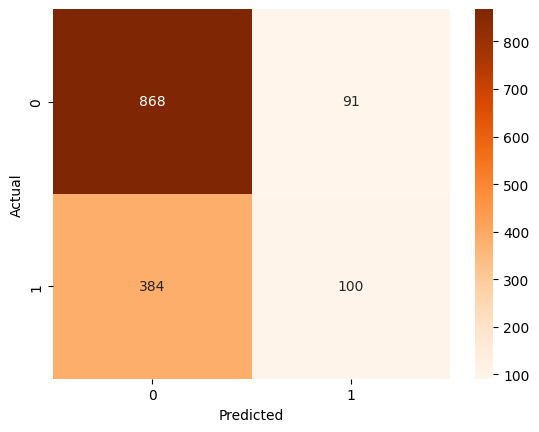

In [9]:
score_model(model_with_selection, X_test, y_test)

### Hyperparameter Tuning for Logistic Regression

In [10]:
# https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
#     'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
lr = LogisticRegression(max_iter=10000, solver='liblinear')
clf = GridSearchCV(lr,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [11]:
# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")

In [12]:
report_GridSearchCV_results(clf)

Best combination of hyperparams:
 {'C': 0.1, 'penalty': 'l2'} 

Best mean_test_score score:
 0.6771760633036598 

Score by fold for best estimator:
 [0.685459940652819, 0.6735905044510386, 0.6409495548961425, 0.658753709198813, 0.6379821958456974, 0.7062314540059347, 0.685459940652819, 0.6845238095238095, 0.6785714285714286, 0.7202380952380952] 



              precision    recall  f1-score   support

           0       0.70      0.90      0.79       959
           1       0.54      0.23      0.32       484

    accuracy                           0.68      1443
   macro avg       0.62      0.57      0.56      1443
weighted avg       0.65      0.68      0.63      1443



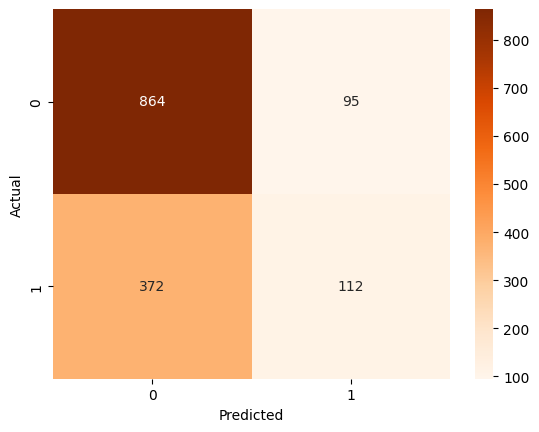

In [13]:
score_model(clf, X_test, y_test)

##### Scale the claimer's age and number of years in position

<div class="alert alert-warning">
    
- Since we KIV `years in position` so there is no need to scale age since it's the only numerical feature remaining

In [14]:
# def yearsago(years, from_date=None):
#     if from_date is None:
#         from_date = datetime.now()
#     try:
#         return from_date.replace(year=from_date.year - years)
#     except ValueError:
#         # Must be 2/29!
#         assert from_date.month == 2 and from_date.day == 29 # can be removed
#         return from_date.replace(month=2, day=28,
#                                  year=from_date.year-years)
# def num_years(begin, end=None):
#     '''Takes in two datetime objects and returns the number of years between them'''
#     if end is None:
#         end = datetime.now()
#     num_years = int((end - begin).days / 365.2425)
#     if begin > yearsago(num_years, end):
#         return num_years - 1
#     else:
#         return num_years

# df2['years in position'] = df2.apply(lambda row: num_years(row['start formatted'], row['claim date formatted']), axis=1)

In [15]:
# plt.figure(figsize=(8,6))
# df2[['claimmer age', 'years in position']].boxplot()
# plt.title('Before scaling numerical variables')

In [16]:
# from sklearn.preprocessing import StandardScaler
# standard_scaler = StandardScaler()

# numerical_variables = ['claimmer age', 'years in position']
# df2[['claimmer age standard scaled', 'years in position standard scaled']] = standard_scaler.fit_transform(df2[numerical_variables])

In [17]:
# plt.figure(figsize=(8,6))
# df2[['claimmer age standard scaled', 'years in position standard scaled']].boxplot()
# plt.title('After scaling numerical variables')

In [18]:
# age_arr = df2['claimmer age standard scaled'].values.reshape(-1,1) #need reshape to 2D else error when stacking
# yop_arr = df2['years in position standard scaled'].values.reshape(-1,1)

#### Age

In [20]:
age_vec_train = X_train['claimer_age'].reset_index().to_numpy()
age_vec_test = X_test['claimer_age'].reset_index().to_numpy()

## Modelling

In [21]:
# # X = np.hstack([age_arr,src_vec.toarray(),issue_vec.toarray(),states_vec.toarray(),yop_arr,claim_vec.toarray()])
# X_train_vec = np.hstack([src_vec_train.toarray(),issue_vec_train.toarray(),states_vec_train.toarray(),claim_vec_train.toarray()])
# X_test_vec = np.hstack([src_vec_test.toarray(),issue_vec_test.toarray(),states_vec_test.toarray(),claim_vec_test.toarray()])
# # y = df2['accuracy']

Features all surrounding the claimer's name(**DON'T USE**, cause overfitting):
'name',
full name',
'name.first',
'name.middle',
'name.last',
'id.wikipedia', 
 
Features Untouched:
- 'id.bioguide'(**not useful as it is a unique id**),
- 'bio.gender'
- 'type',
- 'party',
- 'end',

Labels:
'accuracy rating', 
'accuracy',

Used:
- 'claim source' -> 'source',
- 'state',
- 'issue',
- 'claim date' -> claim date formatted', 'bio.birthday' -> 'birthdate formatted' -> 
- 'claimmer age' -> 'claimmer age scaled',
- 'start',
- 'claim'

### RandomForest Baseline Model with all features

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

clf = RandomForestClassifier(random_state=42, n_estimators=100)
# clf = RandomForestClassifier(random_state=42)
# clf.fit(X_train_vec, y_train)
clf.fit(X_train, y_train)
        
# y_train_pred = clf.predict(X_train_vec)
y_train_pred = clf.predict(X_train)
print('Training Accuracy: ', metrics.accuracy_score(y_train, y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_train,y_train_pred))
print()
# y_test_pred = clf.predict(X_test_vec)
y_test_pred = clf.predict(X_test)
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_test_pred))
print(classification_report(y_test,y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

Training Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2236
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      3367
   macro avg       1.00      1.00      1.00      3367
weighted avg       1.00      1.00      1.00      3367

[[2236    0]
 [   0 1131]]

Test Accuracy:  0.6673596673596673
              precision    recall  f1-score   support

           0       0.68      0.93      0.79       959
           1       0.52      0.14      0.22       484

    accuracy                           0.67      1443
   macro avg       0.60      0.54      0.50      1443
weighted avg       0.63      0.67      0.60      1443

[[895  64]
 [416  68]]


### Hyperparameter tuning for RandomForest

#### RandomizedSearchCV

In [23]:
# randomised search

from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

distributions = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#  'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]}
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = distributions, cv = 3, n_jobs = 2)
rf_random.fit(X_train, y_train)

report_GridSearchCV_results(rf_random)

Best combination of hyperparams:
 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 60, 'bootstrap': False} 

Best mean_test_score score:
 0.6768607980173639 

Score by fold for best estimator:
 [0.686553873552983, 0.6684491978609626, 0.6755793226381461] 



              precision    recall  f1-score   support

           0       0.69      0.94      0.80       959
           1       0.57      0.14      0.23       484

    accuracy                           0.68      1443
   macro avg       0.63      0.54      0.51      1443
weighted avg       0.65      0.68      0.61      1443



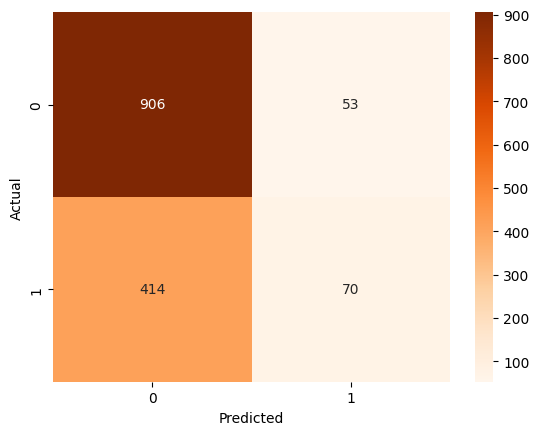

In [24]:
score_model(rf_random, X_test, y_test)

#### GridSearchCV

In [25]:
# grid search

from sklearn.model_selection import GridSearchCV

# param_grid = {
#     # 'bootstrap': [True],
#     'max_depth': [70, 80, 90, 100],
#     # 'max_features': [2, 3],
#     'min_samples_leaf': [1, 2, 3],
#     # 'min_samples_split': [5, 10, 15],
#     'n_estimators': [1600, 1800, 2000]
# }
# rf = RandomForestClassifier(random_state = 42)
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = 2, verbose = 2)
# grid_search.fit(X_train_vec, y_train)

# print(grid_search.best_params_)

rf = RandomForestClassifier(random_state=42)
grid_rf = {
    "max_depth": [5, 50, 75, 100],
    'min_samples_split': [12, 16, 20],
    'criterion': ['gini', 'entropy']
}
rf_grid = GridSearchCV(estimator = rf,      # model
                   param_grid = grid_rf,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 50, 75, 100],
                         'min_samples_split': [12, 16, 20]},
             scoring='accuracy')

In [26]:
report_GridSearchCV_results(rf_grid)

Best combination of hyperparams:
 {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 20} 

Best mean_test_score score:
 0.6807227638830013 

Score by fold for best estimator:
 [0.6795252225519288, 0.6884272997032641, 0.6824925816023739, 0.6824925816023739, 0.6824925816023739, 0.6676557863501483, 0.6884272997032641, 0.6845238095238095, 0.6726190476190477, 0.6785714285714286] 



              precision    recall  f1-score   support

           0       0.68      0.95      0.79       959
           1       0.50      0.11      0.17       484

    accuracy                           0.67      1443
   macro avg       0.59      0.53      0.48      1443
weighted avg       0.62      0.67      0.58      1443



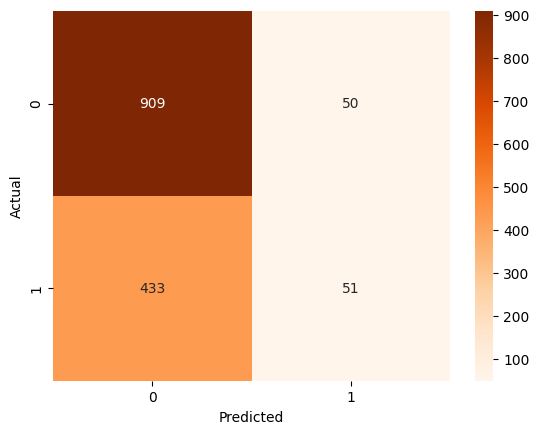

In [27]:
# performance on test set
score_model(rf_grid, X_test, y_test)

#### Feature selection (SelectKBest) / Dimensionality reduction (PCA)

Select K best

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import make_pipeline

k = 350

model_with_selection = make_pipeline(
    SelectKBest(score_func=f_classif, k=k),
    RandomForestClassifier(random_state = 42),
)

model_with_selection.fit(X_train, y_train)


train_pred = model_with_selection.predict(X_train)
print(classification_report(y_train,train_pred))

test_pred = model_with_selection.predict(X_test)
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2236
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      3367
   macro avg       1.00      1.00      1.00      3367
weighted avg       1.00      1.00      1.00      3367

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       959
           1       0.52      0.26      0.34       484

    accuracy                           0.67      1443
   macro avg       0.61      0.57      0.56      1443
weighted avg       0.64      0.67      0.63      1443



PCA

In [29]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

d = np.argmax(cumsum >= 0.95) + 1
print(d)

pca = PCA(n_components=d)
train_features = pca.fit_transform(X_train)
test_features = pca.transform(X_test)

# lin_clf = LinearSVC(random_state = 42)
# lin_clf.fit(train_features, y_train)

# train_pred = lin_clf.predict(train_features)
# print(lin_clf.score(train_features, y_train))
# test_pred = lin_clf.predict(test_features)
# print(lin_clf.score(test_features, y_test))

rfr = RandomForestClassifier(random_state = 42)
rfr.fit(train_features, y_train)

train_pred = rfr.predict(train_features)
print(classification_report(y_train,train_pred))
test_pred = rfr.predict(test_features)
print(classification_report(y_test,test_pred))

1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2236
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      3367
   macro avg       1.00      1.00      1.00      3367
weighted avg       1.00      1.00      1.00      3367

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       959
           1       0.33      0.32      0.33       484

    accuracy                           0.55      1443
   macro avg       0.50      0.50      0.50      1443
weighted avg       0.55      0.55      0.55      1443



#### Trying other classifiers

Gradient boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# gbc=GradientBoostingClassifier(random_state = 42)
gbc = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1,random_state = 42) # max_features=5

gbc.fit(X_train, y_train)

print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

0.8431838431838432
0.6611226611226612


In [31]:
# randomised search for GB

params = {'learning_rate':[0.01,0.05,0.1],
'n_estimators':np.arange(100,500,100)}

search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), params, random_state=42, cv=3)

gb_rand_search = search.fit(X_train, y_train)
print('Best Hyperparameters: %s' % gb_rand_search.best_params_)
print('Best Score: %s' % gb_rand_search.best_score_)

Best Hyperparameters: {'n_estimators': 100, 'learning_rate': 0.05}
Best Score: 0.67240976101172


Linear SVC

In [32]:
# from sklearn.svm import SVC
from sklearn.svm import LinearSVC

lin_clf = LinearSVC(random_state = 42)
lin_clf.fit(X_train, y_train)

print(lin_clf.score(X_train, y_train))
print(lin_clf.score(X_test, y_test))

0.36382536382536385
0.35343035343035345


In [33]:
# randomised search for linear SVC

params = {'C': [0.01, 0.1, 1, 10, 20, 30],
'penalty':['l1', 'l2']}

search = RandomizedSearchCV(LinearSVC(random_state = 42), params, random_state=42, cv=3)

rand_search = search.fit(X_train, y_train)
print('Best Hyperparameters: %s' % rand_search.best_params_)
print('Best Score: %s' % rand_search.best_score_)

Best Hyperparameters: {'penalty': 'l2', 'C': 0.01}
Best Score: 0.6640926048500297


Logistic regression

In [34]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print(log_reg.score(X_train, y_train))
print(log_reg.score(X_test, y_test))

0.6816156816156816
0.659043659043659


K neighbours

In [35]:
# try K neighbours

from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

print(knc.score(X_train, y_train))
print(knc.score(X_test, y_test))

0.7258687258687259
0.6036036036036037


In [36]:
# randomised search for kn

params = {'n_neighbors': [1, 5, 10, 20, 30, 40, 50]}

knc_search = RandomizedSearchCV(KNeighborsClassifier(), params, random_state=42, cv=3)

knc_rand_search = knc_search.fit(X_train, y_train)
print('Best Hyperparameters: %s' % knc_rand_search.best_params_)
print('Best Score: %s' % knc_rand_search.best_score_)

Best Hyperparameters: {'n_neighbors': 50}
Best Score: 0.6528032406194891
